# Reinforcement Learning w/ NBA

## Overview

In Next Best Action (NBA) recommender, we want to predict the timing of the next best email to send to a customer at a point in time. This notebook is going to utilize a fake dataset to help demonstrate a potential approach for NBA. Here we give a brief introduction to some of the elements of our problem space.

- Refinforcement (cold start problem)
- Injecting randomness (exploration)

In [102]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input
import matplotlib.pyplot as plt

import gym_adserver
import gym
from gym import envs

from epsilon_greedy_agent import EpsilonGreedyAgent
from random_agent import RandomAgent
from softmax_agent import SoftmaxAgent
from ucb1_agent import UCB1Agent

from gym import logger, spaces
from gym.utils import seeding
from joblib import Parallel, delayed

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
import math

%matplotlib inline


In [2]:
import sys
new_path = '/Users/req89250/Repositories/POCs/gym-adserver/gym_adserver_example/wrappers'

if new_path not in sys.path:
    sys.path.append(new_path)

new_path = '/Users/req89250/Repositories/POCs/gym-adserver/gym_adserver_example/agents'

if new_path not in sys.path:
    sys.path.append(new_path)

## Learning Distributions

Source: https://github.com/taboola/mdn-tensorflow-notebook-example/blob/master/mdn-tf2.ipynb

In [4]:
def f(x):
    return x**2-6*x+9

In [5]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

In [ ]:
# A noisy distribution
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

In [35]:
x_test

array([1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5,
       3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9])

In [36]:
# probability of response
y_arr

array([1.44399281, 0.13358057, 1.21516606, ..., 3.2800603 , 2.66247631,
       0.44572473])

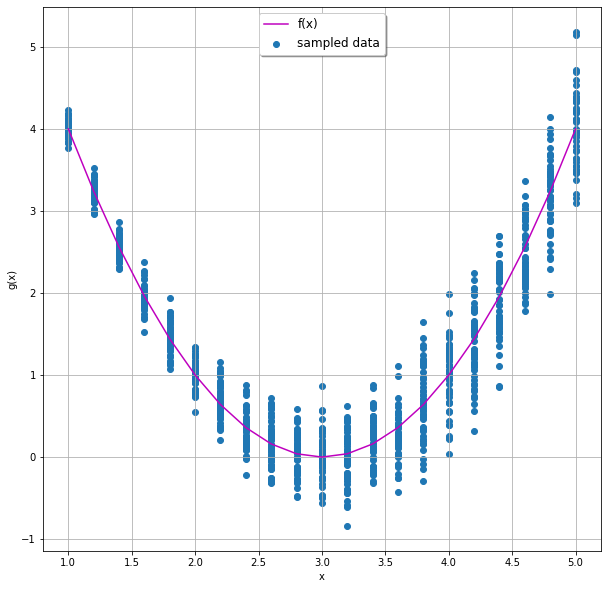

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

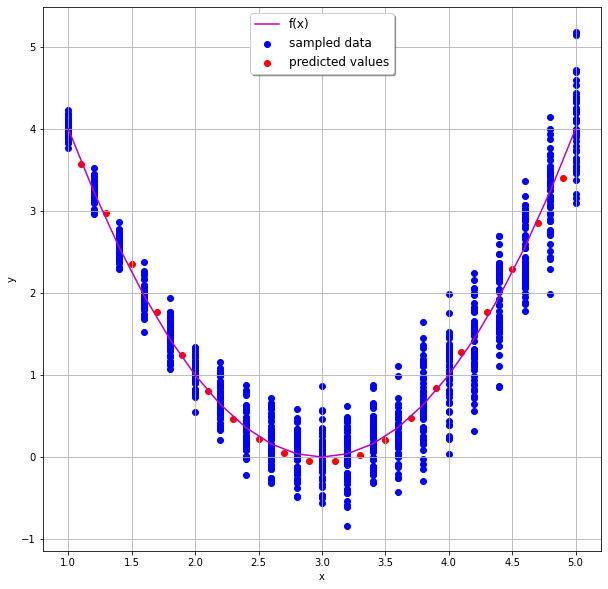

Final cost: 0.1102


In [8]:

epochs = 500
batch_size = 50
learning_rate = 0.0003
model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(history_cache.history['mse'][-1]))

In [21]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

Final cost: 0.2316


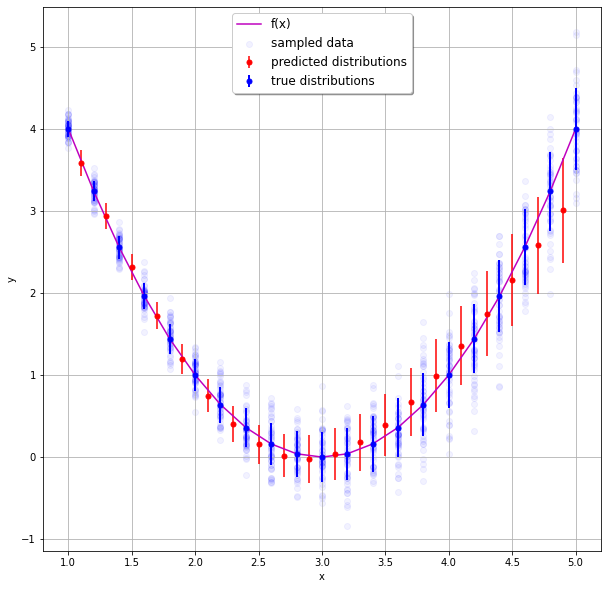

In [34]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((x_test,x_test))) # the model expects a list of arrays as it has 2 inputs
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred).ravel(),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Reinforcement Learning


Here are the 3 basic steps:
1. Agent starts in a state (s1) takes an action (a1) and receives a reward (r1)
2. Agent selects action by referencing their strategy
3. Update strategy

In [20]:
gym_adserver.register

<function gym.envs.registration.register(id, **kwargs)>

In [74]:
# initialize the ennviornemnt
env = gym.make(id='AdServer-v0', 
               num_ads=5, 
               time_series_frequency=90, 
               # TODO: Reward Policy
               reward_policy=lambda x: reward_policy(x)
              )

In [5]:
from gym.utils import seeding

In [7]:
seed=1234

In [8]:
np_random, seed = seeding.np_random(seed)

In [76]:
# TODO: I need the state passed to the reward policy in order to determine reward properly
# TODO: off-policy reinforcement learning?
def reward_policy(x):
    # No reward for no action
    if x == 0:
        return 0
    # Negative reward for week 1
    if x == 1:
        return -1
    # Else a positive reward
    return 1



The environent will generate 10 (num_ads) ads with different performance rates and the agent, without prior knowledge, will learn to select the most performant ones. The simulation will last 10000 iterations (impressions).

During the initialization, the environment assigns to each ad a "Probability" to be clicked. Such a probability is known by the environment only and will be used to draw the rewards during the simulation. The "Actual CTR" is the CTR actually occurred during the simulation: with time, it approximates the probability.

The effective agent will give most impressions to the most performant ads.

### Espsilon Greedy

This algorithm is based on a probability of exploration. The agent has a set likely hood ε that it will explore. This algorithm can be improved by implementing one of the many alternative algorithms such as a decaying epsilon, optimistic initial values, Contextual-Epsilon-greedy and many more. But here we will look at the most simplest form of epsilon-greedy.

In [83]:
from epsilon_greedy_agent import EpsilonGreedyAgent

envs = []
impressions=300
seed=0
agent = EpsilonGreedyAgent(seed=seed, epsilon=0.1)

for t in range(100):
        # Simulation loop
        reward = 0
        observation = env.reset(agent.name)
        envs.append(env)
        for i in range(impressions):
            # Action/Feedback
            # TODO: If the ad has been taken, reduce the action space
            ad_index = agent.act(observation=observation, reward=reward, done=False)
            print(f'Action: Email Index {ad_index}')
            observation, reward, done, info = env.step(ad_index)
            print(f"""Observations:\n Emails: {observation[0]}\n itterations: {observation[1]}\n CTR: {observation[2]}\n Reward: {reward}\n""")
        if done:
            print("Finished after {} timesteps".format(t+1))
            break

Action: Email Index 0
Observations:
 Emails: [(0/1), (0/0), (0/0), (0/0), (0/0)]
 itterations: 1
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (0/0)]
 itterations: 2
 CTR: 0
 Reward: 0

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (1/1)]
 itterations: 3
 CTR: 1
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (2/2)]
 itterations: 4
 CTR: 2
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (3/3)]
 itterations: 5
 CTR: 3
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (4/4)]
 itterations: 6
 CTR: 4
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (5/5)]
 itterations: 7
 CTR: 5
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (6/6)]
 itterations: 8
 CTR: 6
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/2), (0/0), (0/0


Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (185/185), (65/65), (9/9)]
 itterations: 280
 CTR: 259
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (186/186), (65/65), (9/9)]
 itterations: 281
 CTR: 260
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (187/187), (65/65), (9/9)]
 itterations: 282
 CTR: 261
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (188/188), (65/65), (9/9)]
 itterations: 283
 CTR: 262
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (189/189), (65/65), (9/9)]
 itterations: 284
 CTR: 263
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (190/190), (65/65), (9/9)]
 itterations: 285
 CTR: 264
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (191/191), (65/65), (9/9)]
 itterations: 286
 CTR: 265
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/4), (192/192), (65/65), (9/9)]
 itterations: 2

Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (4/4)]
 itterations: 24
 CTR: 4
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (5/5)]
 itterations: 25
 CTR: 5
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (6/6)]
 itterations: 26
 CTR: 6
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (7/7)]
 itterations: 27
 CTR: 7
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (8/8)]
 itterations: 28
 CTR: 8
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (9/9)]
 itterations: 29
 CTR: 9
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/20), (0/0), (0/0), (0/0), (10/10)]
 itterations: 30
 CTR: 10
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/20), (0/0), (0/0), (1/1), (10/10)]
 itterations: 31
 CTR: 11
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/20), (0/0), (0/

Action: Email Index 1
Observations:
 Emails: [(0/15), (0/5), (145/145), (6/6), (3/3)]
 itterations: 174
 CTR: 154
 Reward: -1

Action: Email Index 0
Observations:
 Emails: [(0/16), (0/5), (145/145), (6/6), (3/3)]
 itterations: 175
 CTR: 154
 Reward: 0

Action: Email Index 3
Observations:
 Emails: [(0/16), (0/5), (145/145), (7/7), (3/3)]
 itterations: 176
 CTR: 155
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/5), (146/146), (7/7), (3/3)]
 itterations: 177
 CTR: 156
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/5), (147/147), (7/7), (3/3)]
 itterations: 178
 CTR: 157
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/5), (148/148), (7/7), (3/3)]
 itterations: 179
 CTR: 158
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/5), (149/149), (7/7), (3/3)]
 itterations: 180
 CTR: 159
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/5), (150/150), (7/7), (3/3)]
 itterations: 181
 CTR: 160
 Re

Action: Email Index 4
Observations:
 Emails: [(0/7), (0/0), (0/0), (0/0), (17/17)]
 itterations: 24
 CTR: 17
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (1/1), (0/0), (17/17)]
 itterations: 25
 CTR: 18
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (2/2), (0/0), (17/17)]
 itterations: 26
 CTR: 19
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (3/3), (0/0), (17/17)]
 itterations: 27
 CTR: 20
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (4/4), (0/0), (17/17)]
 itterations: 28
 CTR: 21
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (5/5), (0/0), (17/17)]
 itterations: 29
 CTR: 22
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (6/6), (0/0), (17/17)]
 itterations: 30
 CTR: 23
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/0), (7/7), (0/0), (17/17)]
 itterations: 31
 CTR: 24
 Reward: 1

Action: Email Index 2
Observatio


Action: Email Index 4
Observations:
 Emails: [(0/8), (0/1), (0/0), (34/34), (2/2)]
 itterations: 45
 CTR: 36
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/8), (0/1), (0/0), (35/35), (2/2)]
 itterations: 46
 CTR: 37
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/8), (0/1), (0/0), (36/36), (2/2)]
 itterations: 47
 CTR: 38
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/8), (0/1), (1/1), (36/36), (2/2)]
 itterations: 48
 CTR: 39
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/8), (0/1), (2/2), (36/36), (2/2)]
 itterations: 49
 CTR: 40
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/8), (0/2), (2/2), (36/36), (2/2)]
 itterations: 50
 CTR: 40
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/8), (0/2), (3/3), (36/36), (2/2)]
 itterations: 51
 CTR: 41
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/8), (0/3), (3/3), (36/36), (2/2)]
 itterations: 52
 CTR: 41
 Reward: -1

Action: Email Index 2
Observa

Observations:
 Emails: [(0/7), (0/7), (242/242), (5/5), (12/12)]
 itterations: 273
 CTR: 259
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (243/243), (5/5), (12/12)]
 itterations: 274
 CTR: 260
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (244/244), (5/5), (12/12)]
 itterations: 275
 CTR: 261
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (245/245), (5/5), (12/12)]
 itterations: 276
 CTR: 262
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (246/246), (5/5), (12/12)]
 itterations: 277
 CTR: 263
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/7), (0/7), (246/246), (5/5), (13/13)]
 itterations: 278
 CTR: 264
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (247/247), (5/5), (13/13)]
 itterations: 279
 CTR: 265
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/7), (248/248), (5/5), (13/13)]
 itterations: 280
 CTR: 266
 Reward: 1

Action

Action: Email Index 2
Observations:
 Emails: [(0/3), (0/1), (3/3), (73/73), (43/43)]
 itterations: 123
 CTR: 119
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/3), (0/2), (3/3), (73/73), (43/43)]
 itterations: 124
 CTR: 119
 Reward: -1

Action: Email Index 0
Observations:
 Emails: [(0/4), (0/2), (3/3), (73/73), (43/43)]
 itterations: 125
 CTR: 119
 Reward: 0

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/2), (4/4), (73/73), (43/43)]
 itterations: 126
 CTR: 120
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/4), (0/3), (4/4), (73/73), (43/43)]
 itterations: 127
 CTR: 120
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/3), (5/5), (73/73), (43/43)]
 itterations: 128
 CTR: 121
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/3), (6/6), (73/73), (43/43)]
 itterations: 129
 CTR: 122
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/3), (7/7), (73/73), (43/43)]
 itterations: 130
 CTR: 123
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/37), (0/0), (60/60), (2/2), (1/1)]
 itterations: 100
 CTR: 63
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/37), (0/0), (61/61), (2/2), (1/1)]
 itterations: 101
 CTR: 64
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/37), (0/0), (62/62), (2/2), (1/1)]
 itterations: 102
 CTR: 65
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/38), (0/0), (62/62), (2/2), (1/1)]
 itterations: 103
 CTR: 65
 Reward: 0

Action: Email Index 2
Observations:
 Emails: [(0/38), (0/0), (63/63), (2/2), (1/1)]
 itterations: 104
 CTR: 66
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/38), (0/0), (64/64), (2/2), (1/1)]
 itterations: 105
 CTR: 67
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/38), (0/0), (65/65), (2/2), (1/1)]
 itterations: 106
 CTR: 68
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/38), (0/0), (66/66), (2/2), (1/1)]
 itterations: 107
 CTR: 69
 Reward: 1

Action: Email In


Action: Email Index 0
Observations:
 Emails: [(0/73), (0/0), (0/0), (0/0), (0/0)]
 itterations: 73
 CTR: 0
 Reward: 0

Action: Email Index 1
Observations:
 Emails: [(0/73), (0/1), (0/0), (0/0), (0/0)]
 itterations: 74
 CTR: 0
 Reward: -1

Action: Email Index 0
Observations:
 Emails: [(0/74), (0/1), (0/0), (0/0), (0/0)]
 itterations: 75
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/75), (0/1), (0/0), (0/0), (0/0)]
 itterations: 76
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/76), (0/1), (0/0), (0/0), (0/0)]
 itterations: 77
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/77), (0/1), (0/0), (0/0), (0/0)]
 itterations: 78
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/78), (0/1), (0/0), (0/0), (0/0)]
 itterations: 79
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/79), (0/1), (0/0), (0/0), (0/0)]
 itterations: 80
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [


Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (51/51), (0/0), (1/1)]
 itterations: 56
 CTR: 52
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (52/52), (0/0), (1/1)]
 itterations: 57
 CTR: 53
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (53/53), (0/0), (1/1)]
 itterations: 58
 CTR: 54
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (54/54), (0/0), (1/1)]
 itterations: 59
 CTR: 55
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (55/55), (0/0), (1/1)]
 itterations: 60
 CTR: 56
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (56/56), (0/0), (1/1)]
 itterations: 61
 CTR: 57
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (57/57), (0/0), (1/1)]
 itterations: 62
 CTR: 58
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/2), (0/2), (58/58), (0/0), (1/1)]
 itterations: 63
 CTR: 59
 Reward: 1

Action: Email Index 2
Observati

Action: Email Index 4
Observations:
 Emails: [(0/13), (0/2), (0/0), (0/0), (7/7)]
 itterations: 22
 CTR: 7
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/13), (0/2), (0/0), (0/0), (8/8)]
 itterations: 23
 CTR: 8
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/13), (0/2), (0/0), (0/0), (9/9)]
 itterations: 24
 CTR: 9
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/13), (0/2), (0/0), (0/0), (10/10)]
 itterations: 25
 CTR: 10
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/13), (0/2), (0/0), (0/0), (11/11)]
 itterations: 26
 CTR: 11
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/14), (0/2), (0/0), (0/0), (11/11)]
 itterations: 27
 CTR: 11
 Reward: 0

Action: Email Index 4
Observations:
 Emails: [(0/14), (0/2), (0/0), (0/0), (12/12)]
 itterations: 28
 CTR: 12
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/14), (0/2), (0/0), (0/0), (13/13)]
 itterations: 29
 CTR: 13
 Reward: 1

Action: Email Index 4
Observation


Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (255/255), (7/7), (4/4)]
 itterations: 279
 CTR: 266
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (256/256), (7/7), (4/4)]
 itterations: 280
 CTR: 267
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (257/257), (7/7), (4/4)]
 itterations: 281
 CTR: 268
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (258/258), (7/7), (4/4)]
 itterations: 282
 CTR: 269
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (259/259), (7/7), (4/4)]
 itterations: 283
 CTR: 270
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (260/260), (7/7), (4/4)]
 itterations: 284
 CTR: 271
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (261/261), (7/7), (4/4)]
 itterations: 285
 CTR: 272
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/4), (262/262), (7/7), (4/4)]
 itterations: 286
 CTR: 273
 Reward: 1



Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (173/173), (47/47), (23/23)]
 itterations: 272
 CTR: 243
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (174/174), (47/47), (23/23)]
 itterations: 273
 CTR: 244
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (175/175), (47/47), (23/23)]
 itterations: 274
 CTR: 245
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (176/176), (47/47), (23/23)]
 itterations: 275
 CTR: 246
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (177/177), (47/47), (23/23)]
 itterations: 276
 CTR: 247
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (178/178), (47/47), (23/23)]
 itterations: 277
 CTR: 248
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (179/179), (47/47), (23/23)]
 itterations: 278
 CTR: 249
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/26), (0/3), (180/180), (47/47), (23/23)]


Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (239/239), (3/3), (7/7)]
 itterations: 259
 CTR: 249
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (240/240), (3/3), (7/7)]
 itterations: 260
 CTR: 250
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (241/241), (3/3), (7/7)]
 itterations: 261
 CTR: 251
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (242/242), (3/3), (7/7)]
 itterations: 262
 CTR: 252
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (243/243), (3/3), (7/7)]
 itterations: 263
 CTR: 253
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/5), (0/5), (243/243), (3/3), (8/8)]
 itterations: 264
 CTR: 254
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (244/244), (3/3), (8/8)]
 itterations: 265
 CTR: 255
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/5), (0/5), (245/245), (3/3), (8/8)]
 itterations: 266
 CTR: 256
 Reward: 1


Action: Email Index 2
Observations:
 Emails: [(0/8), (0/3), (185/185), (5/5), (20/20)]
 itterations: 221
 CTR: 210
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/8), (0/3), (186/186), (5/5), (20/20)]
 itterations: 222
 CTR: 211
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/8), (0/3), (187/187), (5/5), (20/20)]
 itterations: 223
 CTR: 212
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/9), (0/3), (187/187), (5/5), (20/20)]
 itterations: 224
 CTR: 212
 Reward: 0

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/3), (188/188), (5/5), (20/20)]
 itterations: 225
 CTR: 213
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/3), (189/189), (5/5), (20/20)]
 itterations: 226
 CTR: 214
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/3), (190/190), (5/5), (20/20)]
 itterations: 227
 CTR: 215
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/9), (0/3), (191/191), (5/5), (20/20)]
 itterations: 228
 CTR: 

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (75/75), (4/4), (2/2)]
 itterations: 127
 CTR: 81
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (76/76), (4/4), (2/2)]
 itterations: 128
 CTR: 82
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (77/77), (4/4), (2/2)]
 itterations: 129
 CTR: 83
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (78/78), (4/4), (2/2)]
 itterations: 130
 CTR: 84
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (79/79), (4/4), (2/2)]
 itterations: 131
 CTR: 85
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (80/80), (4/4), (2/2)]
 itterations: 132
 CTR: 86
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (81/81), (4/4), (2/2)]
 itterations: 133
 CTR: 87
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/43), (0/3), (82/82), (4/4), (2/2)]
 itterations: 134
 CTR: 88
 Reward: 1

Action: Email In


Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (128/128), (10/10), (0/0)]
 itterations: 171
 CTR: 138
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (129/129), (10/10), (0/0)]
 itterations: 172
 CTR: 139
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (130/130), (10/10), (0/0)]
 itterations: 173
 CTR: 140
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (131/131), (10/10), (0/0)]
 itterations: 174
 CTR: 141
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (132/132), (10/10), (0/0)]
 itterations: 175
 CTR: 142
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (133/133), (10/10), (0/0)]
 itterations: 176
 CTR: 143
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (134/134), (10/10), (0/0)]
 itterations: 177
 CTR: 144
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/29), (0/4), (135/135), (10/10), (0/0)]
 itterations: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (68/68), (84/84), (12/12)]
 itterations: 179
 CTR: 164
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (69/69), (84/84), (12/12)]
 itterations: 180
 CTR: 165
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (70/70), (84/84), (12/12)]
 itterations: 181
 CTR: 166
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (71/71), (84/84), (12/12)]
 itterations: 182
 CTR: 167
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (72/72), (84/84), (12/12)]
 itterations: 183
 CTR: 168
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/2), (73/73), (84/84), (12/12)]
 itterations: 184
 CTR: 169
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/13), (0/3), (73/73), (84/84), (12/12)]
 itterations: 185
 CTR: 169
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/13), (0/3), (74/74), (84/84), (12/12)]
 itterations: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (107/107), (3/3), (2/2)]
 itterations: 120
 CTR: 112
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (108/108), (3/3), (2/2)]
 itterations: 121
 CTR: 113
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (109/109), (3/3), (2/2)]
 itterations: 122
 CTR: 114
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (110/110), (3/3), (2/2)]
 itterations: 123
 CTR: 115
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (111/111), (3/3), (2/2)]
 itterations: 124
 CTR: 116
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (112/112), (3/3), (2/2)]
 itterations: 125
 CTR: 117
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (113/113), (3/3), (2/2)]
 itterations: 126
 CTR: 118
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/1), (114/114), (3/3), (2/2)]
 itterations: 127
 CTR: 119
 Reward: 1




Action: Email Index 0
Observations:
 Emails: [(0/15), (0/1), (0/0), (0/0), (0/0)]
 itterations: 16
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/16), (0/1), (0/0), (0/0), (0/0)]
 itterations: 17
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/17), (0/1), (0/0), (0/0), (0/0)]
 itterations: 18
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/18), (0/1), (0/0), (0/0), (0/0)]
 itterations: 19
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/19), (0/1), (0/0), (0/0), (0/0)]
 itterations: 20
 CTR: 0
 Reward: 0

Action: Email Index 1
Observations:
 Emails: [(0/19), (0/2), (0/0), (0/0), (0/0)]
 itterations: 21
 CTR: 0
 Reward: -1

Action: Email Index 0
Observations:
 Emails: [(0/20), (0/2), (0/0), (0/0), (0/0)]
 itterations: 22
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/21), (0/2), (0/0), (0/0), (0/0)]
 itterations: 23
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (20/20), (22/22), (0/0)]
 itterations: 66
 CTR: 42
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (21/21), (22/22), (0/0)]
 itterations: 67
 CTR: 43
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (22/22), (22/22), (0/0)]
 itterations: 68
 CTR: 44
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (23/23), (22/22), (0/0)]
 itterations: 69
 CTR: 45
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (24/24), (22/22), (0/0)]
 itterations: 70
 CTR: 46
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (25/25), (22/22), (0/0)]
 itterations: 71
 CTR: 47
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (26/26), (22/22), (0/0)]
 itterations: 72
 CTR: 48
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/21), (0/3), (27/27), (22/22), (0/0)]
 itterations: 73
 CTR: 49
 Reward: 1

Action: 

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (199/199), (52/52), (8/8)]
 itterations: 281
 CTR: 259
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (200/200), (52/52), (8/8)]
 itterations: 282
 CTR: 260
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (201/201), (52/52), (8/8)]
 itterations: 283
 CTR: 261
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (202/202), (52/52), (8/8)]
 itterations: 284
 CTR: 262
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/16), (0/6), (202/202), (53/53), (8/8)]
 itterations: 285
 CTR: 263
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (203/203), (53/53), (8/8)]
 itterations: 286
 CTR: 264
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (204/204), (53/53), (8/8)]
 itterations: 287
 CTR: 265
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/6), (205/205), (53/53), (8/8)]
 itterations: 28

Observations:
 Emails: [(0/6), (0/4), (260/260), (23/23), (4/4)]
 itterations: 297
 CTR: 287
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/6), (0/4), (261/261), (23/23), (4/4)]
 itterations: 298
 CTR: 288
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/6), (0/4), (262/262), (23/23), (4/4)]
 itterations: 299
 CTR: 289
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/6), (0/4), (263/263), (23/23), (4/4)]
 itterations: 300
 CTR: 290
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/1), (0/0), (0/0), (0/0), (0/0)]
 itterations: 1
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (0/0)]
 itterations: 2
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/3), (0/0), (0/0), (0/0), (0/0)]
 itterations: 3
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/4), (0/0), (0/0), (0/0), (0/0)]
 itterations: 4
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [


Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (82/82), (74/74), (7/7)]
 itterations: 180
 CTR: 163
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/17), (0/1), (82/82), (74/74), (7/7)]
 itterations: 181
 CTR: 163
 Reward: 0

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (83/83), (74/74), (7/7)]
 itterations: 182
 CTR: 164
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (84/84), (74/74), (7/7)]
 itterations: 183
 CTR: 165
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (85/85), (74/74), (7/7)]
 itterations: 184
 CTR: 166
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (86/86), (74/74), (7/7)]
 itterations: 185
 CTR: 167
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (87/87), (74/74), (7/7)]
 itterations: 186
 CTR: 168
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/17), (0/1), (88/88), (74/74), (7/7)]
 itterations: 187
 CTR: 169
 Re

Observations:
 Emails: [(0/4), (0/4), (156/156), (7/7), (2/2)]
 itterations: 173
 CTR: 165
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (157/157), (7/7), (2/2)]
 itterations: 174
 CTR: 166
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (158/158), (7/7), (2/2)]
 itterations: 175
 CTR: 167
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (159/159), (7/7), (2/2)]
 itterations: 176
 CTR: 168
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (160/160), (7/7), (2/2)]
 itterations: 177
 CTR: 169
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (161/161), (7/7), (2/2)]
 itterations: 178
 CTR: 170
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (162/162), (7/7), (2/2)]
 itterations: 179
 CTR: 171
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/4), (163/163), (7/7), (2/2)]
 itterations: 180
 CTR: 172
 Reward: 1

Action: Email Index 2


Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (104/104), (38/38), (4/4)]
 itterations: 158
 CTR: 146
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (105/105), (38/38), (4/4)]
 itterations: 159
 CTR: 147
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (106/106), (38/38), (4/4)]
 itterations: 160
 CTR: 148
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (107/107), (38/38), (4/4)]
 itterations: 161
 CTR: 149
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (108/108), (38/38), (4/4)]
 itterations: 162
 CTR: 150
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (109/109), (38/38), (4/4)]
 itterations: 163
 CTR: 151
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (110/110), (38/38), (4/4)]
 itterations: 164
 CTR: 152
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/7), (0/5), (111/111), (38/38), (4/4)]
 itterations: 165
 CTR: 


Action: Email Index 2
Observations:
 Emails: [(0/1), (0/2), (41/41), (13/13), (20/20)]
 itterations: 77
 CTR: 74
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/1), (0/3), (41/41), (13/13), (20/20)]
 itterations: 78
 CTR: 74
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (42/42), (13/13), (20/20)]
 itterations: 79
 CTR: 75
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (43/43), (13/13), (20/20)]
 itterations: 80
 CTR: 76
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (44/44), (13/13), (20/20)]
 itterations: 81
 CTR: 77
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (45/45), (13/13), (20/20)]
 itterations: 82
 CTR: 78
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (46/46), (13/13), (20/20)]
 itterations: 83
 CTR: 79
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/1), (0/3), (47/47), (13/13), (20/20)]
 itterations: 84
 CTR: 80
 Reward: 1

Observations:
 Emails: [(0/11), (0/4), (261/261), (16/16), (7/7)]
 itterations: 299
 CTR: 284
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/11), (0/4), (262/262), (16/16), (7/7)]
 itterations: 300
 CTR: 285
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/1), (0/0), (0/0), (0/0), (0/0)]
 itterations: 1
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/2), (0/0), (0/0), (0/0), (0/0)]
 itterations: 2
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/3), (0/0), (0/0), (0/0), (0/0)]
 itterations: 3
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/4), (0/0), (0/0), (0/0), (0/0)]
 itterations: 4
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/5), (0/0), (0/0), (0/0), (0/0)]
 itterations: 5
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/6), (0/0), (0/0), (0/0), (0/0)]
 itterations: 6
 CTR: 0
 Reward: 0

Action: Email Index 0
Observations:
 Emails: [(0/7), (0/0), (0/0

Observations:
 Emails: [(0/19), (0/6), (225/225), (20/20), (6/6)]
 itterations: 276
 CTR: 251
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (226/226), (20/20), (6/6)]
 itterations: 277
 CTR: 252
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (227/227), (20/20), (6/6)]
 itterations: 278
 CTR: 253
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (228/228), (20/20), (6/6)]
 itterations: 279
 CTR: 254
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (229/229), (20/20), (6/6)]
 itterations: 280
 CTR: 255
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (230/230), (20/20), (6/6)]
 itterations: 281
 CTR: 256
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (231/231), (20/20), (6/6)]
 itterations: 282
 CTR: 257
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/19), (0/6), (232/232), (20/20), (6/6)]
 itterations: 283
 CTR: 258
 Reward: 1


Action: Email Index 2
Observations:
 Emails: [(0/17), (0/8), (254/254), (6/6), (7/7)]
 itterations: 292
 CTR: 267
 Reward: 1

Action: Email Index 0
Observations:
 Emails: [(0/18), (0/8), (254/254), (6/6), (7/7)]
 itterations: 293
 CTR: 267
 Reward: 0

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (255/255), (6/6), (7/7)]
 itterations: 294
 CTR: 268
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (256/256), (6/6), (7/7)]
 itterations: 295
 CTR: 269
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (257/257), (6/6), (7/7)]
 itterations: 296
 CTR: 270
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (258/258), (6/6), (7/7)]
 itterations: 297
 CTR: 271
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (259/259), (6/6), (7/7)]
 itterations: 298
 CTR: 272
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/18), (0/8), (260/260), (6/6), (7/7)]
 itterations: 299
 CTR: 273
 Re

Observations:
 Emails: [(0/22), (0/5), (206/206), (29/29), (3/3)]
 itterations: 265
 CTR: 238
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/5), (207/207), (29/29), (3/3)]
 itterations: 266
 CTR: 239
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/5), (208/208), (29/29), (3/3)]
 itterations: 267
 CTR: 240
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/5), (209/209), (29/29), (3/3)]
 itterations: 268
 CTR: 241
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/5), (210/210), (29/29), (3/3)]
 itterations: 269
 CTR: 242
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/22), (0/6), (210/210), (29/29), (3/3)]
 itterations: 270
 CTR: 242
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/6), (211/211), (29/29), (3/3)]
 itterations: 271
 CTR: 243
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/22), (0/6), (212/212), (29/29), (3/3)]
 itterations: 272
 CTR: 244
 Reward: 

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (106/106), (39/39), (4/4)]
 itterations: 154
 CTR: 149
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (107/107), (39/39), (4/4)]
 itterations: 155
 CTR: 150
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (108/108), (39/39), (4/4)]
 itterations: 156
 CTR: 151
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (109/109), (39/39), (4/4)]
 itterations: 157
 CTR: 152
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (110/110), (39/39), (4/4)]
 itterations: 158
 CTR: 153
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/1), (111/111), (39/39), (4/4)]
 itterations: 159
 CTR: 154
 Reward: 1

Action: Email Index 1
Observations:
 Emails: [(0/4), (0/2), (111/111), (39/39), (4/4)]
 itterations: 160
 CTR: 154
 Reward: -1

Action: Email Index 2
Observations:
 Emails: [(0/4), (0/2), (112/112), (39/39), (4/4)]
 itterations: 161
 CTR:

Action: Email Index 4
Observations:
 Emails: [(0/16), (0/1), (108/108), (3/3), (39/39)]
 itterations: 167
 CTR: 150
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/16), (0/1), (108/108), (4/4), (39/39)]
 itterations: 168
 CTR: 151
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (109/109), (4/4), (39/39)]
 itterations: 169
 CTR: 152
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (110/110), (4/4), (39/39)]
 itterations: 170
 CTR: 153
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (111/111), (4/4), (39/39)]
 itterations: 171
 CTR: 154
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (112/112), (4/4), (39/39)]
 itterations: 172
 CTR: 155
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/16), (0/1), (113/113), (4/4), (39/39)]
 itterations: 173
 CTR: 156
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/16), (0/1), (113/113), (4/4), (40/40)]
 itterations: 17

Observations:
 Emails: [(0/29), (0/1), (0/0), (0/0), (2/2)]
 itterations: 32
 CTR: 2
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/29), (0/1), (0/0), (0/0), (3/3)]
 itterations: 33
 CTR: 3
 Reward: 1

Action: Email Index 4
Observations:
 Emails: [(0/29), (0/1), (0/0), (0/0), (4/4)]
 itterations: 34
 CTR: 4
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (1/1), (4/4)]
 itterations: 35
 CTR: 5
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (2/2), (4/4)]
 itterations: 36
 CTR: 6
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (3/3), (4/4)]
 itterations: 37
 CTR: 7
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (4/4), (4/4)]
 itterations: 38
 CTR: 8
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (5/5), (4/4)]
 itterations: 39
 CTR: 9
 Reward: 1

Action: Email Index 3
Observations:
 Emails: [(0/29), (0/1), (0/0), (6

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (53/53), (1/1), (1/1)]
 itterations: 82
 CTR: 55
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (54/54), (1/1), (1/1)]
 itterations: 83
 CTR: 56
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (55/55), (1/1), (1/1)]
 itterations: 84
 CTR: 57
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (56/56), (1/1), (1/1)]
 itterations: 85
 CTR: 58
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (57/57), (1/1), (1/1)]
 itterations: 86
 CTR: 59
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (58/58), (1/1), (1/1)]
 itterations: 87
 CTR: 60
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (59/59), (1/1), (1/1)]
 itterations: 88
 CTR: 61
 Reward: 1

Action: Email Index 2
Observations:
 Emails: [(0/24), (0/3), (60/60), (1/1), (1/1)]
 itterations: 89
 CTR: 62
 Reward: 1

Action: Email Index 2
Ob

In [49]:
def render_environment(env, i, **kwargs):
    if kwargs['output_file'] is not None:
        kwargs['output_file'] = str(i) + "_" + kwargs['output_file']
    env.render(**kwargs)
    env.close()

Starting Random Agent
Action: Ad 4
Observations:
 ads: [(0/0), (0/0), (0/0), (0/0), (1/1)]
 itterations: 1
 CTR: 1
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/0), (0/0), (1/1), (0/0), (1/1)]
 itterations: 2
 CTR: 2
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/0), (0/0), (2/2), (0/0), (1/1)]
 itterations: 3
 CTR: 3
 Reward: 1

Action: Ad 0
Observations:
 ads: [(0/1), (0/0), (2/2), (0/0), (1/1)]
 itterations: 4
 CTR: 3
 Reward: 0

Action: Ad 1
Observations:
 ads: [(0/1), (0/1), (2/2), (0/0), (1/1)]
 itterations: 5
 CTR: 3
 Reward: -1

Action: Ad 3
Observations:
 ads: [(0/1), (0/1), (2/2), (1/1), (1/1)]
 itterations: 6
 CTR: 4
 Reward: 1

Action: Ad 1
Observations:
 ads: [(0/1), (0/2), (2/2), (1/1), (1/1)]
 itterations: 7
 CTR: 4
 Reward: -1

Action: Ad 3
Observations:
 ads: [(0/1), (0/2), (2/2), (2/2), (1/1)]
 itterations: 8
 CTR: 5
 Reward: 1

Action: Ad 1
Observations:
 ads: [(0/1), (0/3), (2/2), (2/2), (1/1)]
 itterations: 9
 CTR: 5
 Reward: -1

Action: Ad 4
Observations:
 ad

Action: Ad 4
Observations:
 ads: [(0/174), (0/179), (177/177), (192/192), (165/165)]
 itterations: 887
 CTR: 534
 Reward: 1

Action: Ad 0
Observations:
 ads: [(0/175), (0/179), (177/177), (192/192), (165/165)]
 itterations: 888
 CTR: 534
 Reward: 0

Action: Ad 2
Observations:
 ads: [(0/175), (0/179), (178/178), (192/192), (165/165)]
 itterations: 889
 CTR: 535
 Reward: 1

Action: Ad 3
Observations:
 ads: [(0/175), (0/179), (178/178), (193/193), (165/165)]
 itterations: 890
 CTR: 536
 Reward: 1

Action: Ad 0
Observations:
 ads: [(0/176), (0/179), (178/178), (193/193), (165/165)]
 itterations: 891
 CTR: 536
 Reward: 0

Action: Ad 4
Observations:
 ads: [(0/176), (0/179), (178/178), (193/193), (166/166)]
 itterations: 892
 CTR: 537
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/176), (0/179), (178/178), (193/193), (167/167)]
 itterations: 893
 CTR: 538
 Reward: 1

Action: Ad 3
Observations:
 ads: [(0/176), (0/179), (178/178), (194/194), (167/167)]
 itterations: 894
 CTR: 539
 Reward: 1



Observations:
 ads: [(0/11), (0/15), (204/204), (205/205), (201/201)]
 itterations: 636
 CTR: 610
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/11), (0/15), (205/205), (205/205), (201/201)]
 itterations: 637
 CTR: 611
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/11), (0/15), (206/206), (205/205), (201/201)]
 itterations: 638
 CTR: 612
 Reward: 1

Action: Ad 3
Observations:
 ads: [(0/11), (0/15), (206/206), (206/206), (201/201)]
 itterations: 639
 CTR: 613
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/11), (0/15), (206/206), (206/206), (202/202)]
 itterations: 640
 CTR: 614
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/11), (0/15), (206/206), (206/206), (203/203)]
 itterations: 641
 CTR: 615
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/11), (0/15), (206/206), (206/206), (204/204)]
 itterations: 642
 CTR: 616
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/11), (0/15), (206/206), (206/206), (205/205)]
 itterations: 643
 CTR: 617
 Reward: 1

Action: Ad 3
Observations:
 a


Action: Ad 2
Observations:
 ads: [(0/12), (0/4), (124/124), (123/123), (123/123)]
 itterations: 386
 CTR: 370
 Reward: 1

Action: Ad 1
Observations:
 ads: [(0/12), (0/5), (124/124), (123/123), (123/123)]
 itterations: 387
 CTR: 370
 Reward: -1

Action: Ad 3
Observations:
 ads: [(0/12), (0/5), (124/124), (124/124), (123/123)]
 itterations: 388
 CTR: 371
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/12), (0/5), (124/124), (124/124), (124/124)]
 itterations: 389
 CTR: 372
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/12), (0/5), (125/125), (124/124), (124/124)]
 itterations: 390
 CTR: 373
 Reward: 1

Action: Ad 3
Observations:
 ads: [(0/12), (0/5), (125/125), (125/125), (124/124)]
 itterations: 391
 CTR: 374
 Reward: 1

Action: Ad 4
Observations:
 ads: [(0/12), (0/5), (125/125), (125/125), (125/125)]
 itterations: 392
 CTR: 375
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/12), (0/5), (126/126), (125/125), (125/125)]
 itterations: 393
 CTR: 376
 Reward: 1

Action: Ad 3
Observati

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (198/198), (22/22), (29/29)]
 itterations: 261
 CTR: 249
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (199/199), (22/22), (29/29)]
 itterations: 262
 CTR: 250
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (200/200), (22/22), (29/29)]
 itterations: 263
 CTR: 251
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (201/201), (22/22), (29/29)]
 itterations: 264
 CTR: 252
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (202/202), (22/22), (29/29)]
 itterations: 265
 CTR: 253
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (203/203), (22/22), (29/29)]
 itterations: 266
 CTR: 254
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (204/204), (22/22), (29/29)]
 itterations: 267
 CTR: 255
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (205/205), (22/22), (29/29)]
 itterations: 268
 CTR: 256
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/7), (0/5), (206/206), (22/2

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (845/845), (42/42), (45/45)]
 itterations: 975
 CTR: 932
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (846/846), (42/42), (45/45)]
 itterations: 976
 CTR: 933
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (847/847), (42/42), (45/45)]
 itterations: 977
 CTR: 934
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (848/848), (42/42), (45/45)]
 itterations: 978
 CTR: 935
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (849/849), (42/42), (45/45)]
 itterations: 979
 CTR: 936
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (850/850), (42/42), (45/45)]
 itterations: 980
 CTR: 937
 Reward: 1

Action: Ad 2
Observations:
 ads: [(0/22), (0/21), (851/851), (42/42), (45/45)]
 itterations: 981
 CTR: 938
 Reward: 1

Action: Ad 1
Observations:
 ads: [(0/22), (0/22), (851/851), (42/42), (45/45)]
 itterations: 982
 CTR: 938
 Reward: -1

Action: Ad 2
Observations:
 ads: [(0/22), (0/22

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

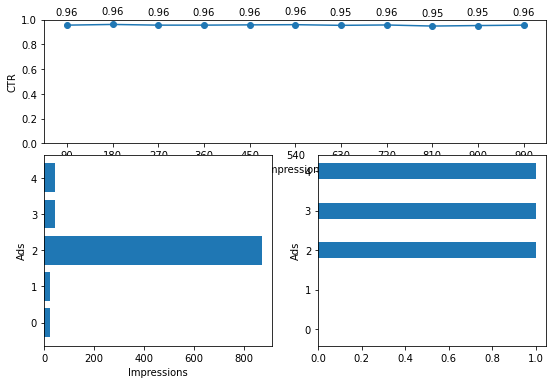

In [119]:
# Compare Agegnts
env='AdServer-v0'
num_ads=5
impressions=1000
seed=0
output_file=None

time_series_frequency = impressions // 10
action_space = spaces.Discrete(num_ads)
max_impressions = impressions

# Define your agents here
agents = [
    RandomAgent(action_space=action_space),
    SoftmaxAgent(seed=seed, beta=5, max_impressions=max_impressions),
    UCB1Agent(action_space=action_space, seed=seed, c=2, max_impressions=max_impressions),
    EpsilonGreedyAgent(seed=seed, epsilon=0.1),
]

envs = []
for agent in agents:
    print('Starting {}'.format(agent.name))
    # initialize the ennviornemnt
    gym_adserver.register
    env = gym.make(id='AdServer-v0',
                   num_ads=num_ads, 
                   time_series_frequency=90, 
                   # TODO: Reward Policy
                   reward_policy=lambda x: reward_policy(x)
                  )
    # Simulation loop
    reward = 0
    observation = env.reset(agent.name)
    envs.append(env)
    for i in range(impressions):
        # Action/Feedback
        # TODO: If the ad has been taken, reduce the action space
        ad_index = agent.act(observation=observation, reward=reward, done=False)
        print(f'Action: Ad {ad_index}')
        observation, reward, done, info = env.step(ad_index)
        print(f"""Observations:\n ads: {observation[0]}\n itterations: {observation[1]}\n CTR: {observation[2]}\n Reward: {reward}\n""")

# Render result for each agent (NOTE: close all to quit)
parallel = Parallel(n_jobs=-1)
env.render()
env.close()
parallel(delayed(render_environment)(env, i, freeze=True, output_file=output_file) for i, env in enumerate(envs))

## Bayesian Optimization

In [112]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [113]:
from bayes_opt import BayesianOptimization

In [114]:
# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

In [115]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [116]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |
|  3        | -7.11     |  2.218    | -0.7867   |
|  4        | -12.4     |  3.66     |  0.9608   |
|  5        | -6.999    |  2.23     | -0.7392   |


In [117]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': -7.135455292718879, 'params': {'x': 2.8340440094051482, 'y': 1.3219469606529488}}
Iteration 1: 
	{'target': -7.779531005607566, 'params': {'x': 2.0002287496346898, 'y': -1.1860045642089614}}
Iteration 2: 
	{'target': -7.109925819441113, 'params': {'x': 2.2175526295255183, 'y': -0.7867249801593896}}
Iteration 3: 
	{'target': -12.397162416009818, 'params': {'x': 3.660003815774634, 'y': 0.9608275029525108}}
Iteration 4: 
	{'target': -6.999472814518675, 'params': {'x': 2.2303920156083024, 'y': -0.7392021938893159}}


## Thompson Sampling

https://github.com/lucko515/ads-strategy-reinforcement-learning

In [103]:
def thompson_sampling(data):

    N = data.shape[0]
    d = data.shape[1]

    N1_n = {} #The number of times the object got reward (1) up to n
    N0_n = {} #The number of tmes the object got 0 up to n

    for i in range(d):
        N1_n[i] = 0
        N0_n[i] = 0

    total_score = 0
    iter_object_selected = []


    for sample in range(N):
        object_results_from_distribution = []

        for object_ in range(d):
            if data[sample, object_] == 1:
                N1_n[object_] += 1
            elif data[sample, object_] == 0:
                N0_n[object_] += 1
            else:
                continue
            object_results_from_distribution.append(random.betavariate(N1_n[object_]+1, N0_n[object_]+1))

        iter_object_selected.append(np.argmax(object_results_from_distribution))
        reward = data[sample, np.argmax(object_results_from_distribution)]
        total_score += reward

    return iter_object_selected, total_score

In [104]:
ads_data = pd.read_csv("Ads_CTR_Optimisation.csv")
ads_data.head()

Ad 1  Ad 2  Ad 3  Ad 4  Ad 5  Ad 6  Ad 7  Ad 8  Ad 9  Ad 10
0     1     0     0     0     1     0     0     0     1      0
1     0     0     0     0     0     0     0     0     1      0
2     0     0     0     0     0     0     0     0     0      0
3     0     1     0     0     0     0     0     1     0      0
4     0     0     0     0     0     0     0     0     0      0

In [105]:
ads_, total_result = thompson_sampling(ads_data.values)

In [106]:
total_result

2704

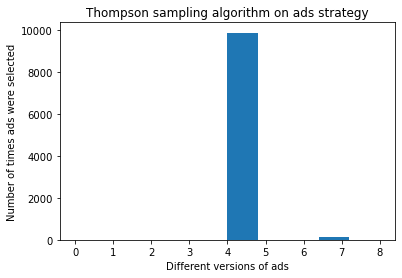

In [107]:
plt.hist(ads_)
plt.title('Thompson sampling algorithm on ads strategy')
plt.xlabel('Different versions of ads')
plt.ylabel('Number of times ads were selected')
plt.show()

## Upper Confidence Bound

In [108]:
import numpy as np


def upper_confidence_bound(data):
    N = data.shape[0]  # number of samples (Example: How many times add was shown, How many times machine was played)
    d = data.shape[1]  # number of dfferent objects (Examples: Different ads, Bandit machines)

    # Ni(n) - the number of times the object 'i' was selected up until the nubmer n
    # Ri(n) - the sum of rewards of the object 'i' up to the number n

    # The idea is to have the best object at each iteration 1-n

    N_i_n = {}
    R_i_n = {}
    iter_object_selected = []
    # Setting starting values
    for i in range(d):
        N_i_n[i] = 0
        R_i_n[i] = 0

    total_results = 0

    # The main loop
    for sample in range(N):
        object_selected = 0
        max_upper_bound = 0

        for object_ in range(d):

            if N_i_n[object_] > 0:
                average_reward = R_i_n[object_] / N_i_n[object_]
                delta_of_object = np.sqrt(3 / 2 * np.log(sample + 1) / N_i_n[object_])
                upper_bound = average_reward + delta_of_object

            else:
                upper_bound = float("+inf")

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                object_selected = object_

        iter_object_selected.append(object_selected)
        N_i_n[object_selected] += 1

        reward = data[sample, object_selected]

        R_i_n[object_selected] += reward

        total_results += reward

    return iter_object_selected, total_results

In [110]:
ads_, total_result = upper_confidence_bound(ads_data.values)

In [111]:
total_result

2178

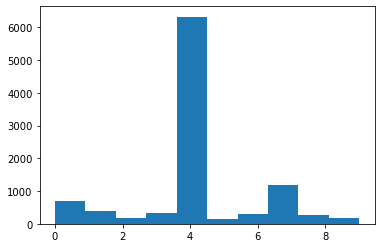

In [92]:
plt.hist(ads_)
plt.show()

## Simulation

In [ ]:
def make_predictions():
    running_acc = 0
    exp_acc = 0
    scores = []
    exp_scores = []
    for i in range(0, len(X), 100):
        X_train = X.drop(['date'], axis=1)
        row = X[['customer_feature_1', 'customer_feature_2', 'email1_response', 'email2_timing']].iloc[i]
        # if fit hasn't been called yet, call it on the first batch
        if i == 0:
    #         model.fit(x=X_train.values, 
    #           y=y, 
    #           batch_size=8,
    #           epochs=200,
    #           validation_split=0.15)
            continue
        else:
            xi = row
            date =  X[['date']].iloc[i]
            yi = y[i]
            # predict
            y_pred = model.predict(np.array([xi,]))[0]


            # Update the running accuracy
            acc = abs(y_pred - yi)
            running_acc += (acc - running_acc) / i

            # Update the exponential moving average
            exp_acc = .1 * acc + .9 * exp_acc

            # Store the metric at the current time
            if i >= 10:
                scores.append((date, running_acc))
                exp_scores.append((date, exp_acc))

            # Finally, make the model learn
            model.partial_fit(np.array([xi,]), [yi])

            if i == 38000:
                break

In [ ]:
def update_models():
    

In [ ]:
def score_models():
    

In [ ]:
def get_sample():
    

In [ ]:
def run_simulation(n=1000):
    get_sample()
    make_predictions(x1, x2, x3)
    # batch datat if statement (i.e. every 100 data points)
    update_models(batch_of_100(x1, x2, x3, y))
    score_models(batch_of_100(x1, x2, x3, y))
    # if statement - at the end, print the model scores and ranks
    

## Next Steps:

Adding context to the reinforcement learning model - contextual bandit

# Q-Learning

Find the best action to take given the current state. Q-learning seeks to learn a policy that maximizes the total reward.

The ‘q’ in q-learning stands for quality. Quality in this case represents how useful a given action is in gaining some future reward

When q-learning is performed we create what’s called a q-table or matrix that follows the shape of [state, action] and we initialize our values to zero. We then update and store our q-values after an episode. This q-table becomes a reference table for our agent to select the best action based on the q-value.

![Simple-value-table-reinforcement-learning.webp](attachment:Simple-value-table-reinforcement-learning.webp)


When the neural network is randomly initialized, it will be predisposed to select certain sub-optimal actions randomly. This may cause the agent to fall into sub-optimal behavior patterns without thoroughly exploring the game and action / reward space.

Here are the 3 basic steps:
1. Agent starts in a state (s1) takes an action (a1) and receives a reward (r1)
2. Agent selects action by referencing Q-table with highest value (max) OR by random (epsilon, ε)
3. Update q-values

# Other Notes

- Rules to limit too similar or too popular of recommendations (remove bias)
    -> consumers are unlikely to action on two messages sent in close succession
- Multi-target (implicit feedback)

- Scale item ratings by user value (i.e. are some attriubtes of actions more "valueable" to the customer or to mutual?)
    -> Composite reward function
    -> heirchtical multitarget recommender system

- How does a neural network recommender system explore?